In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

hour = '08'  # Set the hour 

# List of all models you have generated results for
MODELS_TO_MERGE = ['merton', 'kou', 'heston', 'bates', 'bsm'] 
BASE_PATH = f'/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/COS_Pricers/Hourly_Results/'

base_model = MODELS_TO_MERGE[0]
main_df = pd.read_csv(f'/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/Data/calibration_data/{hour}/btc_{hour}_0dte_data.csv')
main_df.rename(columns={
    'fitted_price': f'{base_model}_fitted_price',
    'fitted_iv': f'{base_model}_fitted_iv'
}, inplace=True)
print(f"Successfully loaded base data from {base_model.upper()} results.")


# We iterate through the rest of the models (from the second one onwards)
for model_name in MODELS_TO_MERGE[0:]:    
    file_path = os.path.join(BASE_PATH, f'Options/{hour}', f'{model_name}_per_option_fits_{hour}.csv')
    # Load the next model's data
    model_df = pd.read_csv(file_path)
    
    # Define the new column names for this model
    price_col = f'{model_name}_fitted_price'
    iv_col = f'{model_name}_fitted_iv'
    
    # Rename the generic columns to be specific to this model
    model_df.rename(columns={'fitted_price': price_col, 'fitted_iv': iv_col}, inplace=True)
    columns_to_merge = ['symbol', price_col, iv_col]
    main_df = pd.merge(main_df, model_df[columns_to_merge], on='symbol', how='left')


# Save the Final Combined DataFrame 
output_folder = os.path.join(BASE_PATH, 'Options')
os.makedirs(output_folder, exist_ok=True)
final_output_path = os.path.join(output_folder, f'{hour}', f'main_per_option_fits_{hour}.csv')

main_df.to_csv(final_output_path, index=False)

print(f"\n--- Merge Complete ---")
print(f"Final combined data saved to: {final_output_path}")

Successfully loaded base data from MERTON results.

--- Merge Complete ---
Final combined data saved to: /Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/COS_Pricers/Hourly_Results/Options/08/main_per_option_fits_08.csv


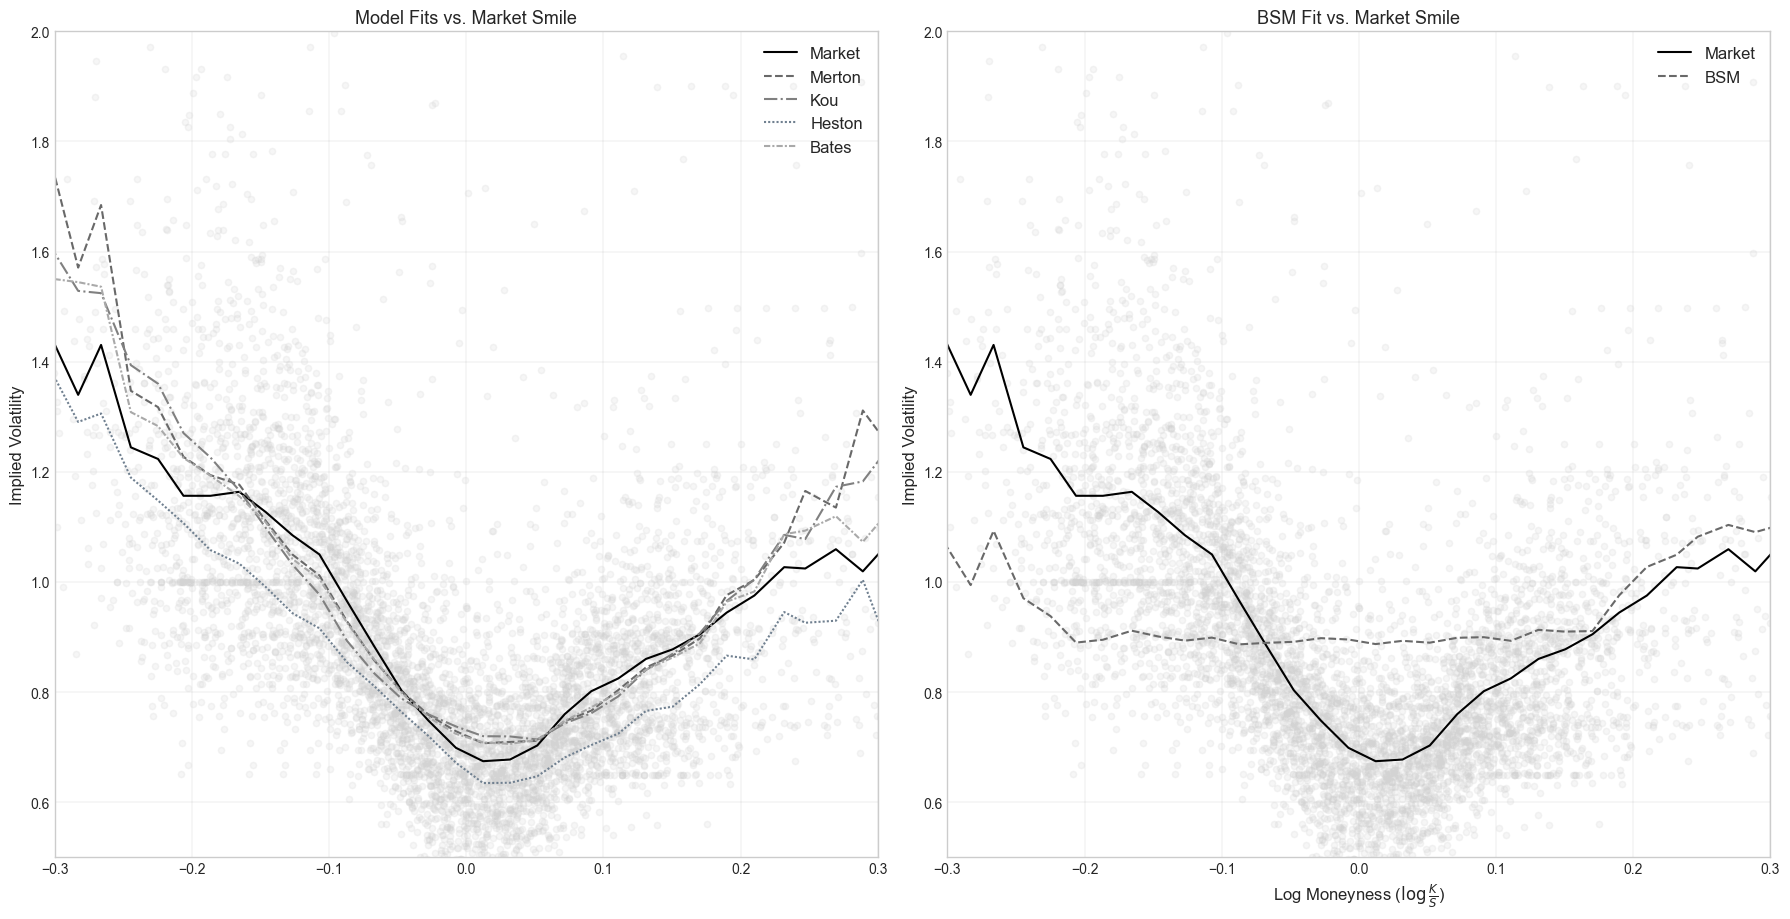

In [7]:
hour = '08'  # Set the hour for plotting
main_df = pd.read_csv(f"//Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/COS_Pricers/Hourly_Results/Options/{hour}/main_per_option_fits_{hour}.csv")

main_df['mark_iv'] = main_df['mark_iv'] / 100
df_filtered = main_df[(main_df['moneyness'] >= -0.4) & (main_df['moneyness'] <= 0.4)].copy()

df_filtered['moneyness_bin'] = pd.cut(df_filtered['moneyness'], bins=40)

agg_dict = {
    'mark_iv': ('mark_iv', 'mean'),
    'moneyness_mid': ('moneyness', 'mean')
}
models_all = ['bsm', 'merton', 'kou', 'heston', 'bates']
for model in models_all:
    agg_dict[f'{model}_fitted_iv'] = (f'{model}_fitted_iv', 'mean')

smoothed_df = df_filtered.groupby('moneyness_bin', observed=True).agg(**agg_dict).dropna()

plt.style.use('seaborn-v0_8-whitegrid')
# Create a figure with two subplots, stacked vertically
fig, axs = plt.subplots(1, 2, figsize=(18, 10), sharex=True)

# Plot 1: Models. 
models_advanced = ['merton', 'kou', 'heston', 'bates']
model_styles = {
    'merton': {'linestyle': '--', 'color': 'dimgray'},
    'kou': {'linestyle': '-.', 'color': 'gray'},
    'heston': {'linestyle': (0, (1, 1)), 'color': 'slategray'},  # densely dotted
    'bates': {'linestyle': (0, (3, 1, 1, 1)), 'color': 'darkgray'}  # dash-dot-dot
}

axs[0].scatter(df_filtered['moneyness'], df_filtered['mark_iv'], color='lightgray', alpha=0.1, s=20, label='_nolegend_')
axs[0].plot(smoothed_df['moneyness_mid'], smoothed_df['mark_iv'], linestyle='-', color='black',
         linewidth=1.5, label='Market')

for model in models_advanced:
    axs[0].plot(smoothed_df['moneyness_mid'], smoothed_df[f'{model}_fitted_iv'],
             linestyle=model_styles[model]['linestyle'],
             color=model_styles[model]['color'],
             linewidth=1.5,
             label=f'{model.capitalize()}')

axs[0].set_ylabel('Implied Volatility', fontsize=12)
axs[0].set_ylim(0.5, 2)
axs[0].set_title('Model Fits vs. Market Smile', fontsize=13)
axs[0].grid(True, linestyle='-', linewidth=0.2, color='gray', alpha=0.5)
axs[0].legend(fontsize=12, loc='upper right')

# BSM Comparison 
axs[1].scatter(df_filtered['moneyness'], df_filtered['mark_iv'], color='lightgray', alpha=0.1, s=20, label='_nolegend_')
axs[1].plot(smoothed_df['moneyness_mid'], smoothed_df['mark_iv'], linestyle='-', color='black',
         linewidth=1.5, label='Market')
axs[1].plot(smoothed_df['moneyness_mid'], smoothed_df['bsm_fitted_iv'],
         linestyle='--',
         color='dimgray',
         linewidth=1.5,
         label='BSM')

axs[1].set_xlabel(r'Log Moneyness ($\log{\frac{K}{S}}$)', fontsize=12)
axs[1].set_ylabel('Implied Volatility', fontsize=12)
axs[1].set_xlim(-0.3, 0.3)
axs[1].set_ylim(0.5, 2)
axs[1].set_title('BSM Fit vs. Market Smile', fontsize=13)
axs[1].grid(True, linestyle='-', linewidth=0.2, color='gray', alpha=0.5)
axs[1].legend(fontsize=12, loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.93]) 
plt.show()


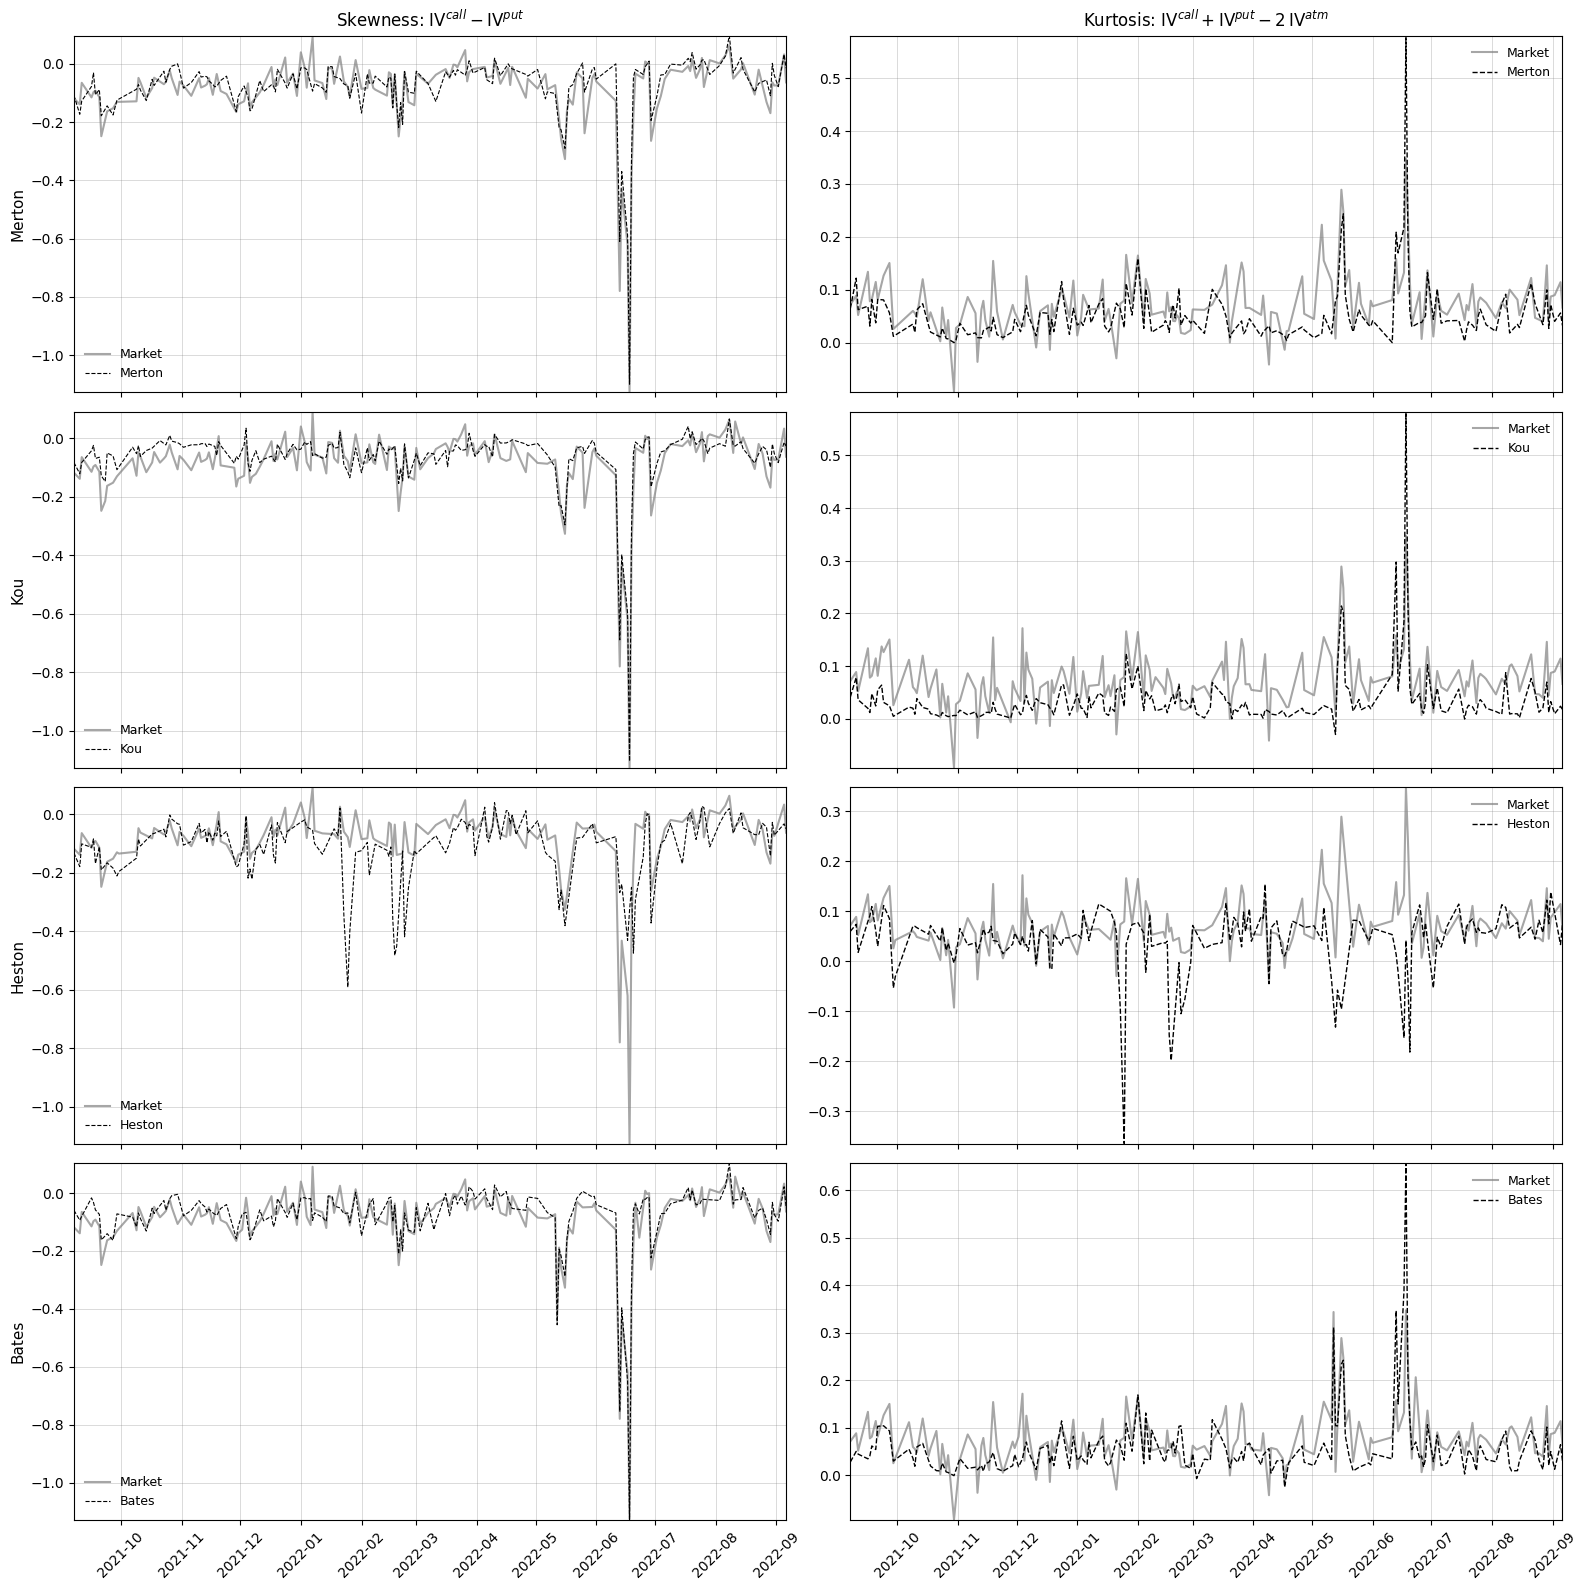

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

SEC_PER_YEAR = 365 * 24 * 3600
hour = '08' 

# Load & prep
df = pd.read_csv(f"//Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/COS_Pricers/Hourly_Results/Options/{hour}/main_per_option_fits_{hour}.csv", 
                 parse_dates=["timestamp", "expiry"])
df = df[df["mark_iv"].notna() & np.isfinite(df["mark_iv"])]
df["date"] = df["timestamp"].dt.date
df["log_moneyness"] = np.log(df["strike"] / df["spot"])
df["tau_yrs"] = df["time_to_maturity"] / SEC_PER_YEAR
df["opt_type"] = df["opt_type"].str.lower()

# Ensure decimals
iv_cols_all = [c for c in df.columns if c.endswith("_iv")]
for col in iv_cols_all:
    if np.nanmedian(df[col]) > 1:
        df[col] /= 100.0

models = ["merton_fitted_iv", "kou_fitted_iv", "heston_fitted_iv", "bates_fitted_iv", "bsm_fitted_iv"]

def pick_nearest(series, target):
    return (series - target).abs().idxmin()

def day_selection_indices(g, anchor_col="mark_iv"):
    if g.empty:
        return None
    atm_idx = g["log_moneyness"].abs().idxmin()
    iv_atm = g.loc[atm_idx, anchor_col]
    tau = g.loc[atm_idx, "tau_yrs"]
    if not (np.isfinite(iv_atm) and iv_atm > 0 and tau > 0):
        return None
    target = iv_atm * np.sqrt(tau)
    calls_pos = g[(g["opt_type"] == "call") & (g["log_moneyness"] > 0)]
    puts_neg  = g[(g["opt_type"] == "put")  & (g["log_moneyness"] < 0)]
    if calls_pos.empty or puts_neg.empty:
        return None
    c_idx = pick_nearest(calls_pos["log_moneyness"], target)
    p_idx = pick_nearest(puts_neg["log_moneyness"], -target)
    return atm_idx, c_idx, p_idx

def compute_series(df, iv_col, anchor="market"):
    rows = []
    anchor_col = "mark_iv" if anchor == "market" else iv_col
    for d, g in df.groupby("date"):
        g = g.sort_values("log_moneyness")
        idxs = day_selection_indices(g, anchor_col=anchor_col)
        if idxs is None:
            continue
        atm_idx, c_idx, p_idx = idxs
        iv_atm = g.loc[atm_idx, iv_col]
        iv_call = g.loc[c_idx, iv_col]
        iv_put  = g.loc[p_idx, iv_col]
        if not (np.isfinite(iv_atm) and np.isfinite(iv_call) and np.isfinite(iv_put)):
            continue
        rows.append({"date": pd.to_datetime(d),
                     "skew": iv_call - iv_put,
                     "convexity": iv_call + iv_put - 2*iv_atm})
    return pd.DataFrame(rows).sort_values("date")

def iv_at_target(g, iv_col, opt_type, target):
    # filter one side
    side = g[g["opt_type"]==opt_type].sort_values("log_moneyness")
    x = side["log_moneyness"].values
    y = side[iv_col].values
    # require both sides of target for safe interpolation
    if not (np.any(x <= target) and np.any(x >= target)):
        return np.nan
    return np.interp(target, x, y)

def compute_series_interp(df, iv_col, anchor="market"):
    rows = []
    for d, g in df.groupby("date"):
        g = g.sort_values("log_moneyness")
        # pick ATM from chosen anchor
        anchor_col = "mark_iv" if anchor=="market" else iv_col
        atm_idx = g["log_moneyness"].abs().idxmin()
        iv_atm = g.loc[atm_idx, iv_col]
        iv_atm_anchor = g.loc[atm_idx, anchor_col]
        tau = g.loc[atm_idx, "tau_yrs"]
        if not (np.isfinite(iv_atm_anchor) and iv_atm_anchor>0 and tau>0): 
            continue
        target = iv_atm_anchor*np.sqrt(tau)

        iv_c = iv_at_target(g[g["log_moneyness"]>0], iv_col, "call",  target)
        iv_p = iv_at_target(g[g["log_moneyness"]<0], iv_col, "put",  -target)
        if np.isfinite(iv_c) and np.isfinite(iv_p) and np.isfinite(iv_atm):
            rows.append({"date": pd.to_datetime(d),
                        "skew": iv_c - iv_p,
                        "convexity": iv_c + iv_p - 2*iv_atm})
    return pd.DataFrame(rows).sort_values("date")

# Compute once for market
market_ts = compute_series(df, "mark_iv", anchor="market")

# Prepare time series for each model
market_ts = compute_series(df, "mark_iv", anchor="market")
mts = {}
for model in ["merton_fitted_iv", "kou_fitted_iv", "heston_fitted_iv", "bates_fitted_iv"]:
    mts[model] = compute_series(df, model, anchor="self").set_index("date")

mt = market_ts.set_index("date")

# Set up 4x2 subplots: rows = models, columns = [skew, convexity]
fig, axs = plt.subplots(4, 2, figsize=(16, 16), sharex=True)
model_labels = {'merton_fitted_iv': 'Merton', 'kou_fitted_iv': 'Kou', 'heston_fitted_iv': 'Heston', 'bates_fitted_iv': 'Bates'}

for i, model in enumerate(["merton_fitted_iv", "kou_fitted_iv", "heston_fitted_iv", "bates_fitted_iv"]):
    both = mt.join(mts[model], how="inner", lsuffix="_mkt", rsuffix="_mdl")
    # Skew subplot
    ax_skew = axs[i, 0]
    ax_skew.plot(both.index, both["skew_mkt"], color='grey', lw=1.5, alpha=0.7, label="Market")
    ax_skew.plot(both.index, both["skew_mdl"], color='black', lw=0.8, ls='--', label=model_labels[model])
    ax_skew.set_xlim(both.index.min(), both.index.max())
    skew_min = np.nanmin([both["skew_mkt"].min(), both["skew_mdl"].min()])
    skew_max = np.nanmax([both["skew_mkt"].max(), both["skew_mdl"].max()])
    ax_skew.set_ylim(skew_min, skew_max)
    if i == 0:
        ax_skew.set_title(r"Skewness: $\mathrm{IV}^{call}-\mathrm{IV}^{put}$", fontsize=12)
    ax_skew.tick_params(axis='x', rotation=45, colors='black')
    ax_skew.tick_params(axis='y', colors='black')
    ax_skew.legend(frameon=False, fontsize=9)
    ax_skew.grid(True, linestyle='-', linewidth=0.4, color='gray', alpha=0.5)
    ax_skew.set_ylabel(model_labels[model], fontsize=11)

    # Convexity subplot
    ax_conv = axs[i, 1]
    ax_conv.plot(both.index, both["convexity_mkt"], color='grey', lw=1.5, alpha=0.7, label="Market")
    ax_conv.plot(both.index, both["convexity_mdl"], color='black', lw=1, ls='--', label=model_labels[model])
    ax_conv.set_xlim(both.index.min(), both.index.max())
    conv_min = np.nanmin([both["convexity_mkt"].min(), both["convexity_mdl"].min()])
    conv_max = np.nanmax([both["convexity_mkt"].max(), both["convexity_mdl"].max()])
    ax_conv.set_ylim(conv_min, conv_max)
    if i == 0:
        ax_conv.set_title(r"Kurtosis: $\mathrm{IV}^{call}+\mathrm{IV}^{put}-2\,\mathrm{IV}^{atm}$", fontsize=12)
    ax_conv.tick_params(axis='x', rotation=45, colors='black')
    ax_conv.tick_params(axis='y', colors='black')
    ax_conv.legend(frameon=False, fontsize=9)
    ax_conv.grid(True, linestyle='-', linewidth=0.4, color='gray', alpha=0.5)

    # Style spines
    for ax in [ax_skew, ax_conv]:
        for spine in ax.spines.values():
            spine.set_color('black')
            spine.set_linewidth(0.8)

plt.tight_layout()
plt.show()

